# Analyzing NYC High School Data

In this project, we analyze the relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. So far, we have combined the following data sets into a single, clean pandas dataframe:

- `SAT scores by school` - SAT scores for each high school in New York City
- `School attendance` - Attendance information for each school in New York City
- `Class size` - Information on class size for each school
- `AP test results` - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- `Graduation outcomes` - The percentage of students who graduated and other outcome information
- `Demographics` - Demographic information for each school
- `School survey` - Surveys of parents, teachers, and students at each school

"New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair."

## Read in the data

In [16]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [17]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [18]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [19]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [20]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [21]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [22]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [23]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [24]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations

In [25]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

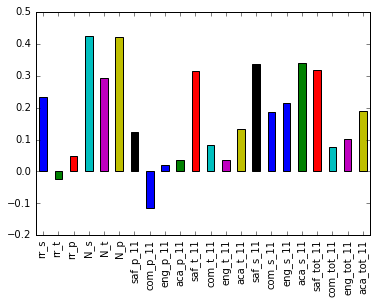

In [26]:
# Set up matplotlib
%matplotlib inline

survey_corr = correlations[survey_fields]
survey_corr.plot.bar()

Based on the above bar chart, the following columns have a  strong positive correlation (0.4) with the SAT score at a school:
- `N_s` - Number of student respondents
- `N_p` - Number of parent respondents

The following columns have a slightly less strong positive correlation (0.3) with the SAT score:
- `N_t` - Number of teacher respondents
- `saf_t_11` - Safety and Respect score based on teacher respones
- `saf_s_11` - Safety and Respect score based on student responses
- `saf_tot_11` - Saftety and Respect total score
- `aca_s_11` - Academic expectations score based on student responses

These results indicate that the perception of safety and respect at a school is very strongly related to the SAT performance of the students. In addition, the students' academic expectations of themselves affects the average SAT score. 

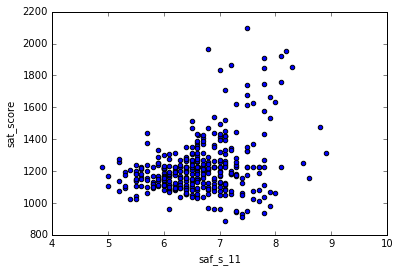

In [27]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

A student safety and respect score of 7 seems to be a threshold value for the SAT scores; below a score of 7, the SAT scores are all less than 1600. Above a safety and respect score of 7, the SAT scores begin to have a wider range, including scores above 1600. At schools with a student safety and respect rating above 8, the SAT scores have a minimum of approximately 1180, an increase of almost 1000 points from the minimum SAT score for a safety rating of 7. No students reported a safety and respect rating of 9 or above.

## Map safety and respect scores

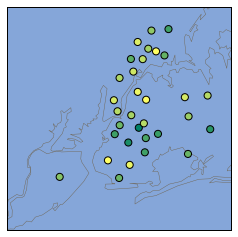

In [28]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

# Compute averages for each district
districts = combined.groupby('school_dist').mean()

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, 
          latlon=True, c=districts['saf_s_11'], 
          cmap='summer')

The map above indicates that Brooklyn is considered the least safest area in New York City. Queens appears to be rated as the safest borough, followed by Manhattan.

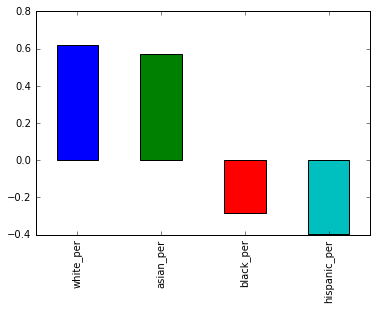

In [30]:
race_fields = ['white_per', 'asian_per', 'black_per', "hispanic_per"]
race_corr = correlations[race_fields]
race_corr.plot.bar()

The correlations show that the percentages of white students and Asian students are both strongly and approximately equally correlated with the average SAT score of a school. Conversely, the percentages of black students and Hispanic students are both negatively correlated with average SAT score, although these correlations appear to be weaker than the positive correlations. 

## Effects of Hispanic percentage

Next, we'll explore the relationships with Hispanic percentage.

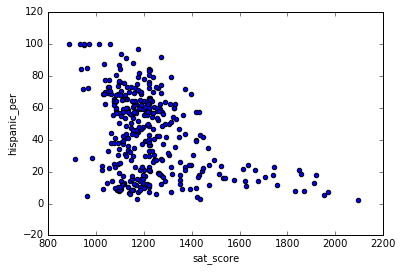

In [31]:
combined.plot.scatter(x='sat_score', y='hispanic_per')

This scatter plot indicates that schools with Hispanic percentages of 0% to 25% have the widest range of SAT scores (900 to 2100). Above 25% Hispanic, the SAT score never goes above 1500, although the minimum SAT score remains approximately the same. 

In [32]:
high_hisp = combined[combined['hispanic_per'] > 95]
print(high_hisp['school_name'])

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object


Many of the schools that have a very Hispanic population (greater than 95%) are high schools that are specifically targeted towards immigrants. 

In [33]:
low_hisp = combined[(combined['hispanic_per'] < 10) 
                    & (combined['sat_score'] > 1800)]
print(low_hisp['school_name'])

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object


The schools on this list are considered the most selective and prestigious high schools in the entire United States. These are specialized high schools with stringent admissions criteria.

## Effects of gender

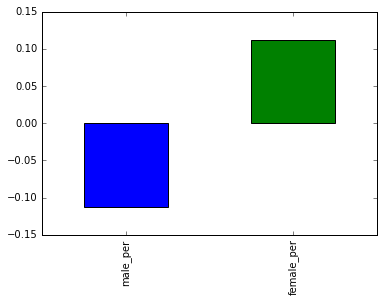

In [34]:
gender_corr = correlations[['male_per', 'female_per']]
gender_corr.plot.bar()

The correlations between gender and SAT scores are quite weak at less than abs(0.12). The percentages of gender at a school appear to not have an effect on the average SAT score of a school.

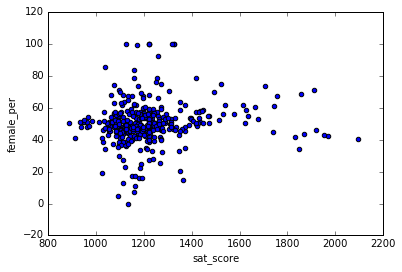

In [35]:
combined.plot.scatter(x='sat_score', y='female_per')

This scatter plot indicates that most schools have an approximately equal gender distribution. The schools that have higher SAT scores (scores greater than 1500) tend to have an approximately equal gender distribution of between 35% and 75% female. The schools with very low and very high percentages of females both have relatively low SAT scores of less than 1400. 

In [36]:
high_fem = combined[(combined['female_per'] > 60) & 
                   (combined['sat_score'] > 1700)]
print(high_fem['school_name'])

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object


The schools that have higher female percentages (greater than 60%) and high SAT scores (greater than 1700) seem to be smaller schools with less than 1200 students and to be magnet schools or otherwise selective. 

## Effect of AP test takers

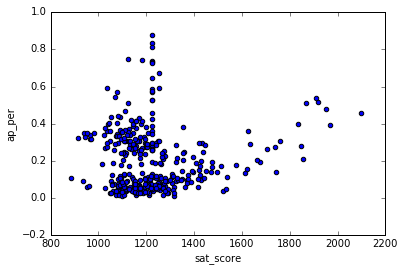

In [38]:
combined['ap_per'] = (combined['AP Test Takers '] / 
                      combined['total_enrollment'])
combined.plot.scatter(x='sat_score', y = 'ap_per')

Interestingly, this scatter plot indicates that the percentage of students who took an AP exam is not strongly correlated with the average SAT score. At the schools with high average SAT scores (greater than 1600), between 15% and 60% of students took at least one AP exam. This range is relatively large and is skewed lower than expected. The few schools where 80% or more of the students took an AP exam had an average SAT score of only 1220, which is surprisingly low.

## Potential Next Steps

- Determine whether there is a correlation between class size and SAT scores.
- Determine which neighborhoods have the best schools; consider combining this information with a dataset containing property values to find the locations with the best valu